<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Main-characters-network:" data-toc-modified-id="Main-characters-network:-1">Main characters network:</a></span></li><li><span><a href="#&quot;All-characters&quot;-network" data-toc-modified-id="&quot;All-characters&quot;-network-2">"All characters" network</a></span><ul class="toc-item"><li><span><a href="#Network-analysis:" data-toc-modified-id="Network-analysis:-2.1">Network analysis:</a></span></li><li><span><a href="#Network-statistics:" data-toc-modified-id="Network-statistics:-2.2">Network statistics:</a></span></li></ul></li></ul></div>

# Network analysis:

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import networkx as nx
from fa2 import ForceAtlas2

import random

## Main characters network:

## "All characters" network

### Network analysis:

In [182]:
# Loading data:
df = pd.read_pickle('../data/Dataset_with_all_scene_characters.pkl')
df_names = pd.read_pickle('../data/Dataset_all_potential_characters.pkl')
all_Names = list(df_names[0])

In [183]:
l=list(np.unique(df.Episode))
seasons = []
seasons.append(l[9:10]+l[18:41])
seasons.append(l[41:64])
seasons.append(l[64:89])
seasons.append(l[89:112])
seasons.append(l[112:135])
seasons.append(l[135:158])
seasons.append(l[158:181])
seasons.append(l[181:204])
seasons.append(l[204:227])
seasons.append(l[0:9]+l[10:18])

In [184]:
ali = ['mon','mnca', 'chanlers', 'chan', 'joe', 'rach', 'phoebs','pheebs']
name = ['monica','monica','chanler','chanlder','joey','rachel','phoebe','phoebe']
alias_dict = dict(zip(ali,name))

In [185]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.01,
                        strongGravityMode=True,
                        gravity=0.005,

                        # Log
                        verbose=False)

In [251]:
N_edges = {}
N_nodes = {}
N_degrees = {}
N_bi_char = {}

plot = False

for s in range(len(seasons)):
    season = seasons[s]
    
    G = nx.Graph()
    for episode in season:
        df_season = df[df.Episode == episode].reset_index(drop = True)
        
        for i in range(len(df_season)):
            node1 = df_season.Speaker[i]
            try: 
                node1 = alias_dict[node1] 
            except:
                node1 = node1            
            
            for node2 in df_season.Scene_characters[i]:
                try: 
                    node2 = alias_dict[node2] 
                except:
                    node2 = node2
                
                if node1 in all_Names:
                    #add edges:
                    if G.has_edge(node1, node2):
                        w = G[node1][node2]['weight']
                        G.add_edge(node1, node2, weight = w + 1)    

                    else:
                        G.add_edge(node1, node2, weight = 1)
        G.remove_edges_from(G.selfloop_edges())

    
    N_nodes[s] = G.number_of_nodes()
    N_edges[s] = G.number_of_edges()
    N_degrees[s] = list(G.degree(['rachel','ross','chandler','monica','joey','phoebe']))
    N_bi_char[s] = sorted(list(G.degree()), key = lambda x: x[1], reverse = True)[6:9]
    
    if plot:
        positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

        colors = dict(zip(list(G.nodes()),['lightblue']*len(G)))
        colors['monica'] = 'steelblue'; colors['rachel'] = 'steelblue'; colors['ross'] = 'steelblue'
        colors['chandler'] = 'steelblue'; colors['phoebe'] = 'steelblue'; colors['joey'] = 'steelblue'

        D = [list(G.degree)[i][1] for i in range(len(G))]
        node_size = [i/(1/max(D)) for i in D]

        W = list(nx.get_edge_attributes(G,'weight').values())
        edge_size = [i*(15/max(W)) for i in W] 

        labels = dict(zip(list(G.nodes()),list(G.nodes())))

        plt.figure(figsize=[15,8])

        nx.draw_networkx_nodes(G, positions, node_color = list(colors.values()), node_size=node_size, with_labels=True, alpha=0.7)
        edges = nx.draw_networkx_edges(G, positions, width = edge_size, edge_color='black', alpha=.9)
        nx.draw_networkx_labels(G, positions, labels ,font_size=16)

        plt.axis('off')
        plt.tight_layout()

        plt.savefig('../figures/S'+str(s)+'network.png')

### Network statistics:

In [252]:
plt.rcParams.update({'font.size': 18})

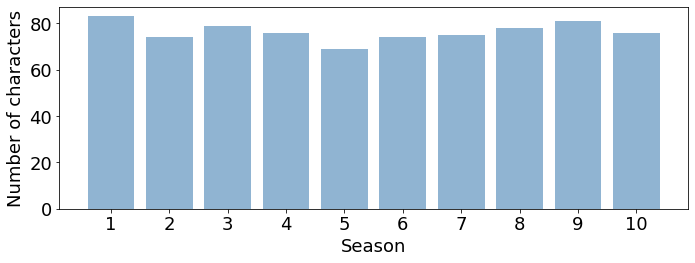

In [305]:
plt.figure(figsize = [10,4])
plt.bar([i+1 for i in N_nodes.keys()],list(N_nodes.values()), color='steelblue',alpha = 0.6);
plt.xlabel('Season');
plt.xticks([i+1 for i in N_nodes.keys()],[i+1 for i in N_nodes.keys()]);
plt.ylabel('Number of characters');
plt.tight_layout()
plt.savefig('../figures/total_number_of_nodes.png')

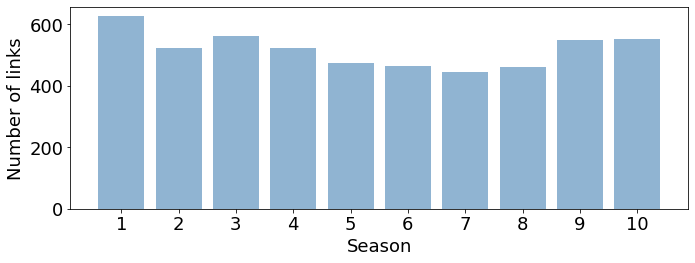

In [306]:
plt.figure(figsize = [10,4])
plt.bar([i+1 for i in N_edges.keys()],list(N_edges.values()), color='steelblue',alpha = 0.6);
plt.xlabel('Season');
plt.xticks([i+1 for i in N_edges.keys()],[i+1 for i in N_edges.keys()]);
plt.ylabel('Number of links');
plt.tight_layout()
plt.savefig('../figures/total_number_of_edges.png')

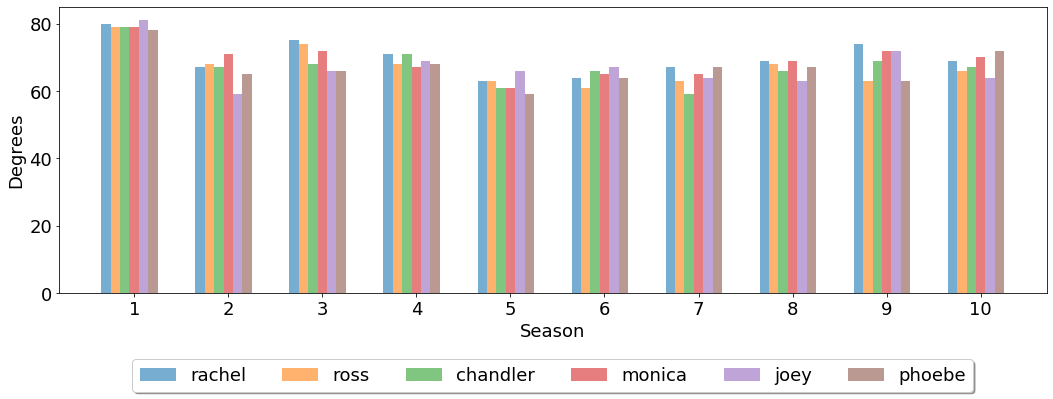

In [312]:
plt.figure(figsize = [15,6])

barwidth = 1/10
for c in range(6):
    x = np.array(range(10)) + (barwidth*c)
    D = [N_degrees[s][c][1] for s in range(10)]

    plt.bar(x, D,alpha = 0.6, width=barwidth);
    

names = [N_degrees[s][i][0] for i in range(6)]
plt.xticks(np.array(range(10))+3/10, list(range(1,11)))
plt.xlim([-0.5,10])
plt.legend(names,
           loc='upper center', bbox_to_anchor=(0.5, -0.2),
           fancybox=True, shadow=True, ncol=6)
plt.xlabel('Season');
plt.ylabel('Degrees');
plt.tight_layout()
plt.savefig('../figures/season_degree_big_network.png')

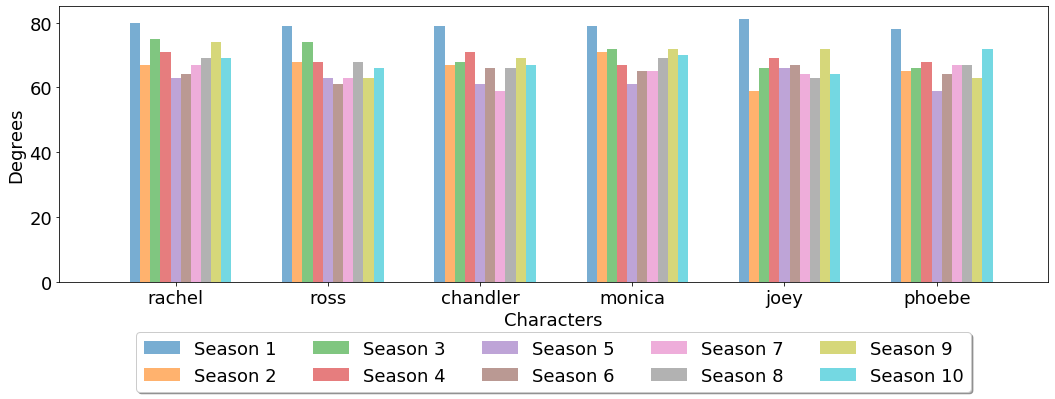

In [313]:
 plt.figure(figsize = [15,6])

barwidth = 1/15
for s in range(10):
    x = np.array(range(6)) + (barwidth*s)
    D = [N_degrees[s][c][1] for c in range(6)]

    plt.bar(x, D,alpha = 0.6, width=barwidth);
    

names = [N_degrees[s][i][0] for i in range(6)]
plt.xticks(np.array(range(6))+4/15, names)
plt.xlim([-0.5,6])
plt.legend(['Season 1','Season 2','Season 3','Season 4','Season 5','Season 6','Season 7','Season 8','Season 9','Season 10'],
           loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.xlabel('Characters');
plt.ylabel('Degrees');
plt.tight_layout()
plt.savefig('../figures/main_characters_degree_big_network.png')

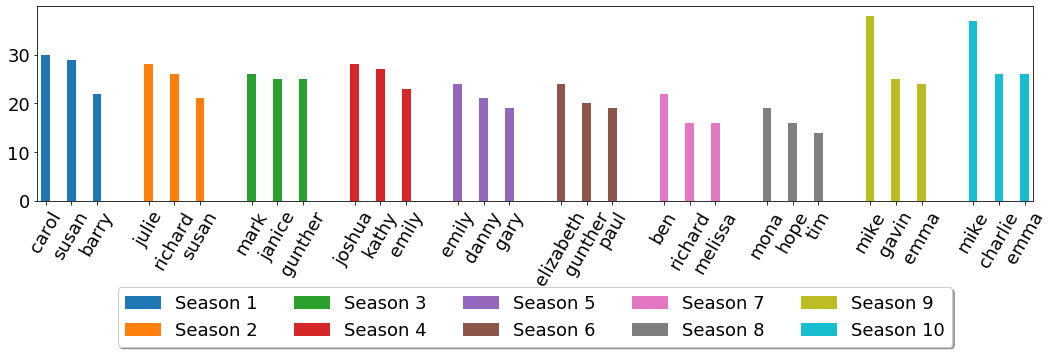

In [319]:
fig = plt.figure(figsize = [15,6])
ax = plt.subplot(111)
barwidth = 1

ticks_L = []
ticks_V = []

for s in range(10):
    x = np.array([0,3,6]) + (12*s)
    D = [N_bi_char[s][c][1] for c in range(3)]
    
    plt.bar(x, D, width = barwidth)
    
    ticks_V.extend(x)
    ticks_L.extend([N_bi_char[s][c][0] for c in range(3)])

plt.xlim([-1,max(ticks_V)+1])
plt.legend(['Season 1','Season 2','Season 3','Season 4','Season 5','Season 6','Season 7','Season 8','Season 9','Season 10'],
           loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=5)
plt.xticks(ticks_V,ticks_L,rotation=60)
plt.tight_layout()
plt.savefig('../figures/bi_characters_degree_big_network.png')